In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm

df = None

for path in Path('data/by_file/token_type').iterdir():  
    print(path.stem, end=' ')
    dfi = pd.read_csv(path)
    dfi = dfi.set_index('num')
    n_docs = dfi.sum(axis=0).max()
    
    tfidf = None
    for col in dfi.columns:
        idx = np.round(dfi.index.values * np.log(dfi[col].sum() / n_docs)).astype(int)
        temp_df = pd.DataFrame(dfi[col].values, index=idx, columns=[col])
        temp_df = temp_df.groupby(axis=0, level=0).sum()
        
        if tfidf is None:
            tfidf = temp_df
        else:
            tfidf = tfidf.join(temp_df, how='outer')

    tfidf.columns = pd.MultiIndex.from_tuples([ (col, path.stem ) for col in tfidf.columns ])
    
    if df is None:
        df = tfidf
    else:
        df = df.join(tfidf, how='outer')
    print(df.shape)

df = df.fillna(0).astype(int)
display(df)

tokens = sorted(set(c[0] for c in df.columns))
datasets = sorted(set(c[1] for c in df.columns))
print('Tokens:\n', tokens)
print('\nDatasets:\n', datasets)

NTR (261, 40)
WILD (451605, 170)
VDC (451605, 298)
BIG (451605, 420)
JLT (451605, 507)
MNY (463126, 626)
CVS (463162, 733)
TBO (463162, 789)


,!=,%,&,(,),*,*=,+=,",",-,...,struct,switch,typedef,union,unsigned,void,wchar_t,while,{,}
,NTR,NTR,NTR,NTR,NTR,NTR,NTR,NTR,NTR,NTR,...,TBO,TBO,TBO,TBO,TBO,TBO,TBO,TBO,TBO,TBO
-14902822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-14902756,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-14681748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-14681684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-14640146,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4,0,3,0,1,1,0,2,0,4,0,...,0,0,0,16,0,16,0,0,0,0
-3,5,0,42,0,0,0,0,0,2,0,...,56,0,64,0,0,0,0,0,0,0
-2,0,13,0,0,0,6,0,0,5,72,...,0,0,0,0,0,0,0,0,0,0


Tokens:
 ['!=', '%', '%=', '&', '&=', '(', ')', '*', '*=', '+', '++', '+=', ',', '-', '--', '-=', '->', '->*', '.', '.*', '...', '/', '/=', ':', '::', ';', '<', '<<=', '<=', '=', '==', '>', '>=', '>>=', '?', 'AndAnd', 'BooleanLiteral', 'CharacterLiteral', 'Directive', 'EOF', 'FloatingLiteral', 'Identifier', 'IntegerLiteral', 'MultiLineMacro', 'Not', 'OrOr', 'PointerLiteral', 'StringLiteral', 'UserDefinedLiteral', '[', ']', '^', '^=', 'alignas', 'alignof', 'asm', 'auto', 'bool', 'break', 'case', 'catch', 'char', 'char16_t', 'char32_t', 'class', 'const', 'const_cast', 'constexpr', 'continue', 'decltype', 'default', 'delete', 'do', 'double', 'dynamic_cast', 'else', 'enum', 'explicit', 'export', 'extern', 'final', 'float', 'for', 'friend', 'goto', 'if', 'inline', 'int', 'long', 'mutable', 'namespace', 'new', 'noexcept', 'operator', 'override', 'private', 'protected', 'public', 'register', 'reinterpret_cast', 'return', 'short', 'signed', 'sizeof', 'static', 'static_assert', 'static_cast', '

In [3]:
from scipy.stats import ks_2samp
from IPython.display import display

GREEN = '#81C784'
RED = '#E57373'

def get_samples(col):
    sample = []
    for val, count in zip(col.index, col):
        try:
            sample += [ val ] * count
        except Exception as e:
            print(val, count)
            raise e
    return sample

def pvalue_reject(val):
    if np.isnan(val): return ''
    return f'background: {RED if val < 0.05 else GREEN}'

ks = pd.DataFrame()

for token in tqdm(tokens):
    df_token = df[token]
    samples = { col: get_samples(df_token[col]) for col in df_token.columns }
    
    for i, ds in enumerate(datasets):
        if ds not in samples or ds == 'WILD' or not samples[ds]: continue
        if not samples['WILD']: continue
        result = ks_2samp(samples['WILD'], samples[ds])
        ks.at[token, ds] = result.pvalue


ks = ks.sort_index(axis=0).sort_index(axis=1)
display((ks > 0.05).sum(axis=0))
display(ks.style.applymap(pvalue_reject))

  0%|          | 0/130 [00:00<?, ?it/s]

BIG     4
CVS     1
JLT     3
MNY     2
NTR    12
TBO     1
VDC     2
dtype: int64

,BIG,CVS,JLT,MNY,NTR,TBO,VDC
!=,0.000000,0.000000,0.000000,0.000000,0.057808,0.000000,0.000000
%,0.000000,0.000000,0.000000,0.000000,0.319722,0.000006,0.000000
%=,0.000000,0.000000,nan,0.000000,nan,nan,0.000000
&,0.000000,0.000000,0.000000,0.000000,0.000000,0.000167,0.000000
&=,0.000000,0.000000,nan,0.000000,nan,nan,0.000000
(,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
*,0.000000,0.000000,0.000000,0.000000,0.106313,0.000000,0.000000
*=,0.000000,0.000000,nan,0.000000,0.407562,nan,0.000000
+,0.000000,0.000000,0.000000,0.000000,nan,0.000000,0.000000


In [5]:
# miss = pd.DataFrame(ks.isna().sum(axis=0), columns=['cnt'])
# miss['%'] = (miss.cnt / ks.shape[0]).round(3) * 100
# miss
old_tokens = tokens

  0%|          | 0/9 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


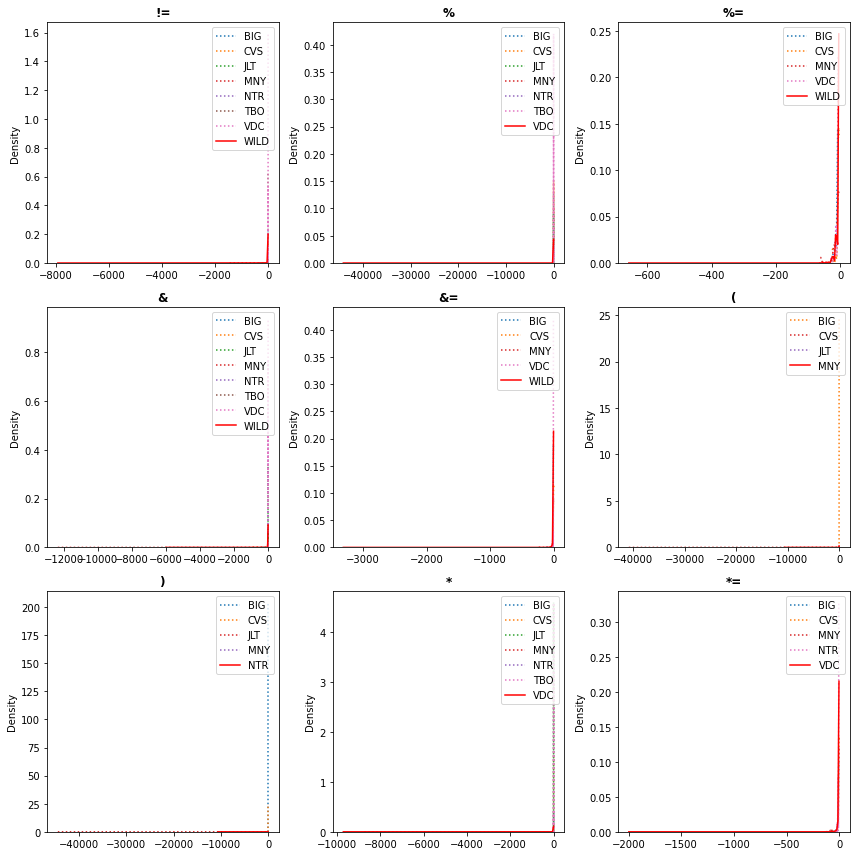

In [42]:
colors = plt.get_cmap('tab10').colors

tokens = old_tokens[:9]

n_cols = 3
n_rows = np.ceil(len(tokens) / n_cols).astype(int)
size = 4
fig, axes = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(n_cols * size, n_rows * size))

for token, ax in tqdm(zip(tokens, axes.ravel()), total=len(tokens)):
    df_token = df[token]
    legend = []
    
    for i, dataset in tqdm(enumerate(datasets), leave=False):
        if dataset not in df_token.columns: continue

        legend.append(dataset)
        x = get_samples(df_token[dataset])
        sns.kdeplot(x=x, ax=ax, cut=0, color=colors[i] if dataset != 'WILD' else 'red', linestyle='dotted' if dataset != 'WILD' else 'solid')

    ax.legend(legend, loc='upper right')
    ax.set_title(token, fontweight='bold')

plt.tight_layout()
# plt.savefig('img/byfile-type-kde.svg')
# plt.savefig('img/byfile-type-kde.jpg')
plt.show()
plt.close()